In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Configuration ---
N_CONSUMERS = 500
N_MONTHS_TOTAL = 36
SIMULATED_DATA_FILENAME = 'electricity_usage.csv'
FIXED_POSTCODE = 50312

def simulate_data_fixed_postcode():
    """
    Simulates 36 months of electricity usage data for 500 consumers,
    all located within the same postcode.
    Introduces some anomalies for a subset of consumers.
    Saves the data to a CSV file.
    """
    print(f"--- Running Step 1: Simulating Data for Postcode {FIXED_POSTCODE} ---")
    
    # Define community characteristics based on new requirements
    building_types = ['middle-row_house', 'corner-house', 'bungalow', 'penthouse']
    base_usage_kwh = {
        'middle-row_house': 500,
        'corner-house': 750,
        'bungalow': 1300,
        'penthouse': 900
    }
    
    records = []
    start_date = datetime(2022, 1, 1)

    # Create a base profile for each consumer
    consumer_profiles = []
    for i in range(1, N_CONSUMERS + 1):
        consumer_profiles.append({
            'consumer_id': f'CID{i:04d}', # Format: CID0001, CID0002, etc.
            'postcode': FIXED_POSTCODE, # Assign the same postcode to all consumers
            'building_type': np.random.choice(building_types)
        })

    # Select a small percentage of consumers to be fraudulent
    fraud_ids = np.random.choice(
        [p['consumer_id'] for p in consumer_profiles], 
        size=int(N_CONSUMERS * 0.05), 
        replace=False
    )

    for profile in consumer_profiles:
        consumer_id = profile['consumer_id']
        base = base_usage_kwh[profile['building_type']]
        is_fraudulent_consumer = consumer_id in fraud_ids

        for i in range(N_MONTHS_TOTAL):
            current_date = start_date + timedelta(days=i*30)
            # Introduce seasonality (e.g., higher usage in warmer months)
            month = current_date.month
            seasonality_factor = 1 + 0.3 * np.sin((month - 3) / 12 * 2 * np.pi)
            
            # Normal usage with some noise
            usage = np.random.normal(loc=base * seasonality_factor, scale=base * 0.1)

            # Inject fraudulent behavior for specific consumers after 1 year
            if is_fraudulent_consumer and i > 12:
                fraud_type = np.random.choice(['low', 'high'])
                if fraud_type == 'low':
                    usage *= np.random.uniform(0.1, 0.4) # Meter tampering
                else:
                    usage *= np.random.uniform(2.5, 4.0) # Energy theft
            
            records.append({
                'consumer_id': consumer_id,
                'postcode': profile['postcode'],
                'building_type': profile['building_type'],
                'month': current_date.strftime('%b%Y'), # Format: Jan2022, Feb2022
                'monthly_usage_kwh': round(max(0, usage), 2)
            })
            
    df = pd.DataFrame(records)
    df.to_csv(SIMULATED_DATA_FILENAME, index=False)
    print(f"Data simulation complete. {len(df)} records saved to '{SIMULATED_DATA_FILENAME}'.")
    print("Sample output:")
    print(df.head())

# --- Main Execution ---
if __name__ == "__main__":
    simulate_data_fixed_postcode()


--- Running Step 1: Simulating Data for Postcode 50312 ---
Data simulation complete. 18000 records saved to 'electricity_usage.csv'.
Sample output:
  consumer_id  postcode     building_type    month  monthly_usage_kwh
0     CID0001     50312  middle-row_house  Jan2022             299.81
1     CID0001     50312  middle-row_house  Jan2022             306.36
2     CID0001     50312  middle-row_house  Mar2022             524.94
3     CID0001     50312  middle-row_house  Apr2022             531.33
4     CID0001     50312  middle-row_house  May2022             701.74


In [2]:
import pandas as pd
import numpy as np

# --- Configuration ---
INPUT_DATA_FILENAME = 'electricity_usage.csv'
PROCESSED_DATA_FILENAME = 'processed_usage_data.csv'
FEATURE_MATRIX_FILENAME = 'feature_matrix.npy'
N_MONTHS_FOR_FEATURE = 12

def feature_engineering():
    """
    Reads the raw usage data, engineers features, and saves the results.
    The key feature is the deviation from the community average.
    """
    print("\n--- Running Step 2: Performing Feature Engineering ---")
    
    try:
        df = pd.read_csv(INPUT_DATA_FILENAME)
    except FileNotFoundError:
        print(f"Error: Input file '{INPUT_DATA_FILENAME}' not found. Please run Step 1 first.")
        return

    # Convert 'month' string to a proper datetime object to extract the month number
    df['date'] = pd.to_datetime(df['month'], format='%b%Y')
    df['month_num'] = df['date'].dt.month
    
    # Calculate the average usage for each community (postcode, building type, month)
    # This defines the "normal" behavior for a community
    df['community_avg_kwh'] = df.groupby(
        ['postcode', 'building_type', 'month_num']
    )['monthly_usage_kwh'].transform('mean')
    
    # Calculate the deviation from the community average
    # We use a small epsilon (1e-6) to avoid division by zero for communities with 0 average
    df['deviation_pct'] = (df['monthly_usage_kwh'] - df['community_avg_kwh']) / (df['community_avg_kwh'] + 1e-6)
    
    # Save the processed data with calculated averages for the prediction step
    df.to_csv(PROCESSED_DATA_FILENAME, index=False)
    print(f"Processed data saved to '{PROCESSED_DATA_FILENAME}'.")

    # --- Create feature matrix for training ---
    all_features = []
    # Sort by consumer and date to ensure windows are created correctly
    df_sorted = df.sort_values(['consumer_id', 'date'])
    
    for cid in df_sorted['consumer_id'].unique():
        consumer_df = df_sorted[df_sorted['consumer_id'] == cid]
        deviations = consumer_df['deviation_pct'].values
        
        # Create overlapping 12-month windows of the deviation values
        for i in range(len(deviations) - N_MONTHS_FOR_FEATURE + 1):
            window = deviations[i : i + N_MONTHS_FOR_FEATURE]
            all_features.append(window)
            
    feature_matrix = np.array(all_features)
    
    # Save the feature matrix for the training script
    np.save(FEATURE_MATRIX_FILENAME, feature_matrix)
    print(f"Feature engineering complete. Matrix of shape {feature_matrix.shape} saved to '{FEATURE_MATRIX_FILENAME}'.")

# --- Main Execution ---
if __name__ == "__main__":
    feature_engineering()


--- Running Step 2: Performing Feature Engineering ---
Processed data saved to 'processed_usage_data.csv'.
Feature engineering complete. Matrix of shape (12500, 12) saved to 'feature_matrix.npy'.


In [3]:
import numpy as np
from sklearn.ensemble import IsolationForest
import joblib

# --- Configuration ---
FEATURE_MATRIX_FILENAME = 'feature_matrix.npy'
MODEL_FILENAME = 'fraud-model.pkl'

def train_model():
    """
    Loads the feature matrix and trains an Isolation Forest model.
    """
    print("\n--- Running Step 3: Training the Isolation Forest Model ---")

    try:
        X_train = np.load(FEATURE_MATRIX_FILENAME)
    except FileNotFoundError:
        print(f"Error: Feature matrix '{FEATURE_MATRIX_FILENAME}' not found. Please run Step 2 first.")
        return

    print(f"Loaded feature matrix with shape: {X_train.shape}")
    
    # Initialize the model.
    # 'contamination' is the expected proportion of anomalies in the dataset.
    # We set it to a small value like 0.05 based on our simulation.
    model = IsolationForest(
        n_estimators=100, 
        contamination=0.05, 
        random_state=42,
        max_features=1.0, 
        max_samples='auto'
    )
    
    print("Training the model...")
    model.fit(X_train)
    
    # Save the trained model to a file
    joblib.dump(model, MODEL_FILENAME)
    print(f"Model training complete. Model saved to '{MODEL_FILENAME}'.")

# --- Main Execution ---
if __name__ == "__main__":
    train_model()



--- Running Step 3: Training the Isolation Forest Model ---
Loaded feature matrix with shape: (12500, 12)
Training the model...
Model training complete. Model saved to 'fraud-model.pkl'.


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- Configuration ---
N_CONSUMERS = 150  # This will generate 150 * 36 = 5400 lines of data
N_MONTHS_TOTAL = 36
N_FRAUD_CONSUMERS = 7
OUTPUT_FILENAME = 'new_data.csv'

def generate_large_data_with_outliers():
    """
    Simulates 36 months of electricity usage data for 150 consumers,
    with 7 consumers having obvious fraudulent (outlier) patterns.
    Saves the data to 'new_data.csv'.
    """
    print(f"--- Generating Large Test Dataset: '{OUTPUT_FILENAME}' ---")
    
    # Define community characteristics
    postcodes = np.random.randint(10000, 80000, size=30)
    building_types = ['middle-row_house', 'corner-house', 'bungalow', 'penthouse']
    base_usage_kwh = {
        'middle-row_house': 500,
        'corner-house': 750,
        'bungalow': 1300,
        'penthouse': 900
    }
    
    records = []
    start_date = datetime(2022, 1, 1)

    # Create base profiles for each consumer
    consumer_profiles = []
    for i in range(1, N_CONSUMERS + 1):
        consumer_profiles.append({
            'consumer_id': f'CID{i:04d}',
            'postcode': np.random.choice(postcodes),
            'building_type': np.random.choice(building_types)
        })

    # Explicitly select the first 7 consumers to be fraudulent
    all_consumer_ids = [p['consumer_id'] for p in consumer_profiles]
    fraud_ids = all_consumer_ids[:N_FRAUD_CONSUMERS]
    print(f"Designated fraud IDs: {fraud_ids}")

    for profile in consumer_profiles:
        consumer_id = profile['consumer_id']
        base = base_usage_kwh[profile['building_type']]
        is_fraudulent_consumer = consumer_id in fraud_ids

        for i in range(N_MONTHS_TOTAL):
            current_date = start_date + timedelta(days=i*30)
            month_of_year = current_date.month
            seasonality_factor = 1 + 0.3 * np.sin((month_of_year - 3) / 12 * 2 * np.pi)
            
            # Normal usage with some noise
            usage = np.random.normal(loc=base * seasonality_factor, scale=base * 0.1)

            # Inject obvious fraudulent behavior for the designated consumers
            if is_fraudulent_consumer and i > 20: # Fraud starts late in the period
                # Drastically reduce usage to simulate meter tampering
                usage *= np.random.uniform(0.05, 0.2)
            
            records.append({
                'consumer_id': consumer_id,
                'postcode': profile['postcode'],
                'building_type': profile['building_type'],
                'month': current_date.strftime('%b%Y'),
                'monthly_usage_kwh': round(max(0, usage), 2)
            })
            
    df = pd.DataFrame(records)
    df.to_csv(OUTPUT_FILENAME, index=False)
    print(f"Data generation complete. {len(df)} records saved to '{OUTPUT_FILENAME}'.")

if __name__ == "__main__":
    generate_large_data_with_outliers()


--- Generating Large Test Dataset: 'new_data.csv' ---
Designated fraud IDs: ['CID0001', 'CID0002', 'CID0003', 'CID0004', 'CID0005', 'CID0006', 'CID0007']
Data generation complete. 5400 records saved to 'new_data.csv'.


In [5]:
import pandas as pd
import numpy as np
import joblib

# --- Configuration ---
MODEL_FILENAME = 'fraud-model.pkl'
DATA_FILENAME = 'new_data.csv' # The single data file to analyze
N_MONTHS_FOR_FEATURE = 12

def analyze_and_report():
    """
    Loads a trained model and a single data file. It analyzes all consumers
    in the file and generates a fraud report.
    """
    print("\n--- Running Analysis and Reporting ---")

    # Load the pre-trained model and the data file
    try:
        model = joblib.load(MODEL_FILENAME)
        df = pd.read_csv(DATA_FILENAME)
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        print(f"Please ensure '{MODEL_FILENAME}' and '{DATA_FILENAME}' exist.")
        print("You may need to run Step 3 (training) and the data generation script first.")
        return

    # --- Perform Feature Engineering on the entire dataset ---
    # This is necessary to establish the "normal" community behavior
    df['date'] = pd.to_datetime(df['month'], format='%b%Y')
    df['month_num'] = df['date'].dt.month
    
    df['community_avg_kwh'] = df.groupby(
        ['postcode', 'building_type', 'month_num']
    )['monthly_usage_kwh'].transform('mean')
    
    df['deviation_pct'] = (df['monthly_usage_kwh'] - df['community_avg_kwh']) / (df['community_avg_kwh'] + 1e-6)

    # --- Analyze each consumer using the trained model ---
    fraud_report = []
    consumer_ids = df['consumer_id'].unique()

    for cid in consumer_ids:
        consumer_df = df[df['consumer_id'] == cid].sort_values('date')

        # We need at least 12 months of data to make a prediction
        if len(consumer_df) < N_MONTHS_FOR_FEATURE:
            continue

        # We will check the most recent 12-month period for each consumer
        deviations = consumer_df['deviation_pct'].values
        # Get the last 12 months of deviations
        feature_vector = deviations[-N_MONTHS_FOR_FEATURE:].reshape(1, -1)

        # --- Make Prediction using the loaded model ---
        prediction = model.predict(feature_vector)
        decision_score = model.decision_function(feature_vector)

        if prediction[0] == -1:
            # If flagged as an anomaly, add to the report
            fraud_report.append({'consumer_id': cid, 'anomaly_score': decision_score[0]})

    # --- Print Final Report ---
    print("\n" + "="*60)
    print("Fraud Detection Report".center(60))
    print("="*60)
    print(f"Total consumers analyzed: {len(consumer_ids)}")
    print(f"Total potential fraud cases detected: {len(fraud_report)}")
    print("-"*60)

    if not fraud_report:
        print("No fraudulent activity detected.")
    else:
        print("Details of Flagged Consumers:")
        report_df = pd.DataFrame(fraud_report)
        report_df = report_df.sort_values(by='anomaly_score').reset_index(drop=True)
        report_df['anomaly_score'] = report_df['anomaly_score'].map('{:.4f}'.format)
        print(report_df.to_string())
    
    print("="*60)


if __name__ == "__main__":
    analyze_and_report()



--- Running Analysis and Reporting ---

                   Fraud Detection Report                   
Total consumers analyzed: 150
Total potential fraud cases detected: 11
------------------------------------------------------------
Details of Flagged Consumers:
   consumer_id anomaly_score
0      CID0004       -0.2930
1      CID0005       -0.2925
2      CID0001       -0.2855
3      CID0006       -0.2855
4      CID0007       -0.2841
5      CID0003       -0.2767
6      CID0002       -0.2675
7      CID0090       -0.1195
8      CID0066       -0.1072
9      CID0115       -0.0333
10     CID0085       -0.0183



--- Running Outlier Plot Generation ---
Total unique consumers found in 'new_data.csv': 150
Analysis complete. Found 11 potentially fraudulent consumers.
Plot generation complete. Displaying plot below.


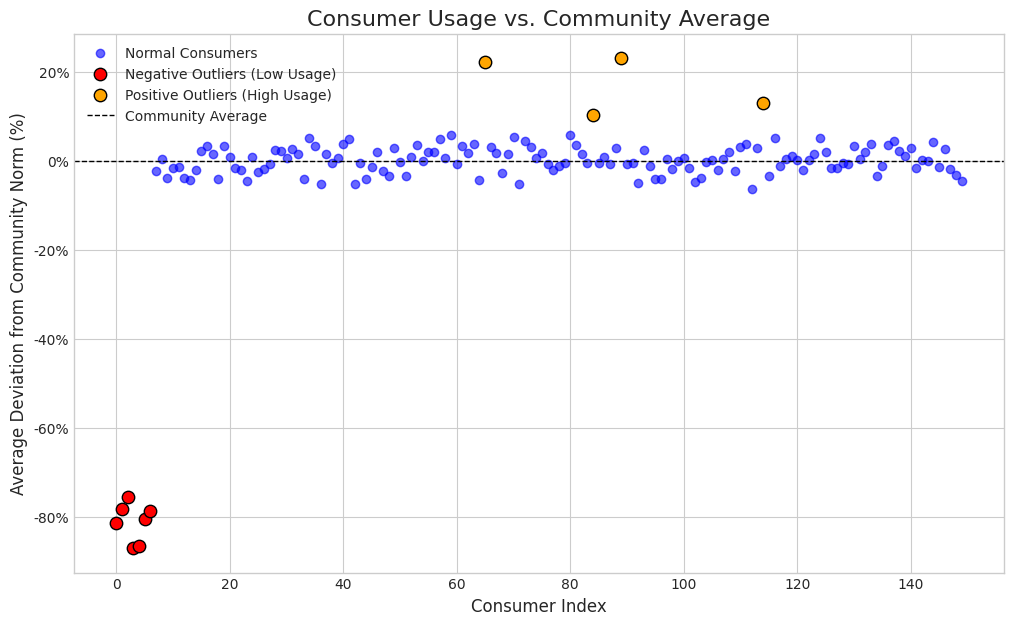

In [6]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# --- Configuration ---
MODEL_FILENAME = 'fraud-model.pkl'
DATA_FILENAME = 'new_data.csv'
N_MONTHS_FOR_FEATURE = 12

def create_outlier_plot():
    """
    Analyzes consumer data, identifies fraud using the ML model, and generates
    a scatter plot to visualize the outliers vs. normal consumers.
    """
    print("\n--- Running Outlier Plot Generation ---")

    # Load the pre-trained model and the data file
    try:
        model = joblib.load(MODEL_FILENAME)
        df = pd.read_csv(DATA_FILENAME)
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        return

    # --- 1. Perform Feature Engineering and Analysis ---
    total_consumers = df['consumer_id'].nunique()
    print(f"Total unique consumers found in '{DATA_FILENAME}': {total_consumers}")

    df['date'] = pd.to_datetime(df['month'], format='%b%Y')
    df['month_num'] = df['date'].dt.month
    df['community_avg_kwh'] = df.groupby(['postcode', 'building_type', 'month_num'])['monthly_usage_kwh'].transform('mean')
    df['deviation_pct'] = (df['monthly_usage_kwh'] - df['community_avg_kwh']) / (df['community_avg_kwh'] + 1e-6)

    analysis_results = []
    consumer_ids = df['consumer_id'].unique()

    for cid in consumer_ids:
        consumer_df = df[df['consumer_id'] == cid].sort_values('date')
        if len(consumer_df) < N_MONTHS_FOR_FEATURE:
            continue
        
        # Get the last 12 months of deviations
        deviations = consumer_df['deviation_pct'].values
        feature_vector = deviations[-N_MONTHS_FOR_FEATURE:].reshape(1, -1)
        
        # Make prediction and get the average deviation for plotting
        prediction = model.predict(feature_vector)
        avg_deviation = np.mean(feature_vector)
        
        status = 'Fraudulent' if prediction[0] == -1 else 'Normal'
        analysis_results.append({'consumer_id': cid, 'avg_deviation_pct': avg_deviation, 'status': status})

    print(f"Analysis complete. Found {len([r for r in analysis_results if r['status'] == 'Fraudulent'])} potentially fraudulent consumers.")

    # --- 2. Prepare Data for Plotting ---
    plot_df = pd.DataFrame(analysis_results)
    
    # Separate normal and fraudulent consumers
    normal_consumers = plot_df[plot_df['status'] == 'Normal']
    all_fraud_consumers = plot_df[plot_df['status'] == 'Fraudulent']
    
    # Further split fraudulent consumers into positive (high usage) and negative (low usage)
    positive_fraud = all_fraud_consumers[all_fraud_consumers['avg_deviation_pct'] > 0]
    negative_fraud = all_fraud_consumers[all_fraud_consumers['avg_deviation_pct'] <= 0]

    # --- 3. Create the Matplotlib Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot normal consumers
    ax.scatter(
        normal_consumers.index,
        normal_consumers['avg_deviation_pct'] * 100,
        color='blue',
        alpha=0.6,
        label='Normal Consumers'
    )
    # Plot negative outliers (low usage)
    ax.scatter(
        negative_fraud.index,
        negative_fraud['avg_deviation_pct'] * 100,
        color='red',
        edgecolor='black',
        s=80, # Make outliers larger
        label='Negative Outliers (Low Usage)',
        zorder=3 # Ensure outliers are plotted on top
    )
    # Plot positive outliers (high usage)
    ax.scatter(
        positive_fraud.index,
        positive_fraud['avg_deviation_pct'] * 100,
        color='orange', # Different color for positive fraud
        edgecolor='black',
        s=80, # Make outliers larger
        label='Positive Outliers (High Usage)',
        zorder=3 # Ensure outliers are plotted on top
    )

    # Add a line for the community average (0% deviation)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, label='Community Average')

    # Formatting the plot
    ax.set_title('Consumer Usage vs. Community Average', fontsize=16)
    ax.set_xlabel('Consumer Index', fontsize=12)
    ax.set_ylabel('Average Deviation from Community Norm (%)', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    # Improve y-axis readability
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    
    print("Plot generation complete. Displaying plot below.")
    plt.show()

if __name__ == "__main__":
    create_outlier_plot()


In [7]:
import pandas as pd
import numpy as np
import joblib
import folium
import random
from folium.plugins import MarkerCluster

# --- Configuration ---
MODEL_FILENAME = 'fraud-model.pkl'
DATA_FILENAME = 'new_data.csv' # Assumes this file was generated by the fixed-postcode script
N_MONTHS_FOR_FEATURE = 12
FIXED_POSTCODE = 50312

# --- Mock Geocoding for KL Postcodes (Improved) ---
def get_kl_coordinates(postcode, consumer_id):
    """
    Generates mock latitude/longitude coordinates. If the postcode matches the
    fixed postcode, it places the consumer in a small, specific area.
    The consumer_id ensures a unique location within that area.
    """
    # Define a small bounding box for the specific postcode 50312
    # This simulates a single neighborhood on the left side of the map.
    fixed_postcode_region = {'lat': (3.135, 3.145), 'lon': (101.620, 101.630)}
    
    # Use a hash of the unique consumer_id for a reproducible random seed.
    # This is the key to ensuring every consumer gets a unique spot.
    random.seed(hash(consumer_id))

    if postcode == FIXED_POSTCODE:
        # If it's our target postcode, place it within the tight cluster.
        coords = fixed_postcode_region
        return (random.uniform(*coords['lat']), random.uniform(*coords['lon']))
    else:
        # Fallback for any other postcodes (should not happen if using the new data)
        return (3.1390, 101.6869)


def create_fraud_map():
    """
    Analyzes consumer data, identifies fraud using the ML model, and generates an
    interactive map visualizing the locations of normal and fraudulent consumers.
    Returns the map object to be displayed in a Jupyter cell.
    """
    print("\n--- Running Fraud Map Generation ---")

    # Load the pre-trained model and the data file
    try:
        model = joblib.load(MODEL_FILENAME)
        df = pd.read_csv(DATA_FILENAME)
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        return

    # --- 1. Perform Fraud Analysis using the ML Model ---
    total_consumers = df['consumer_id'].nunique()
    print(f"Total unique consumers found in '{DATA_FILENAME}': {total_consumers}")
    
    df['date'] = pd.to_datetime(df['month'], format='%b%Y')
    df['month_num'] = df['date'].dt.month
    df['community_avg_kwh'] = df.groupby(['postcode', 'building_type', 'month_num'])['monthly_usage_kwh'].transform('mean')
    df['deviation_pct'] = (df['monthly_usage_kwh'] - df['community_avg_kwh']) / (df['community_avg_kwh'] + 1e-6)

    flagged_consumers = {}
    consumer_ids = df['consumer_id'].unique()

    for cid in consumer_ids:
        consumer_df = df[df['consumer_id'] == cid].sort_values('date')
        if len(consumer_df) < N_MONTHS_FOR_FEATURE:
            continue
        
        deviations = consumer_df['deviation_pct'].values
        feature_vector = deviations[-N_MONTHS_FOR_FEATURE:].reshape(1, -1)
        
        prediction = model.predict(feature_vector)
        if prediction[0] == -1:
            decision_score = model.decision_function(feature_vector)
            flagged_consumers[cid] = decision_score[0]

    print(f"Analysis complete. Found {len(flagged_consumers)} potentially fraudulent consumers.")

    # --- 2. Prepare Data for Mapping ---
    locations_df = df[['consumer_id', 'postcode']].drop_duplicates().reset_index(drop=True)
    locations_df['is_fraud'] = locations_df['consumer_id'].apply(lambda x: x in flagged_consumers)
    locations_df['anomaly_score'] = locations_df['consumer_id'].map(flagged_consumers)
    
    # Apply the updated function to get unique coordinates for each consumer
    coords = locations_df.apply(
        lambda row: get_kl_coordinates(row['postcode'], row['consumer_id']),
        axis=1
    )
    locations_df['latitude'] = [c[0] for c in coords]
    locations_df['longitude'] = [c[1] for c in coords]

    # --- 3. Create the Folium Map using MarkerCluster ---
    # Center the map on the new housing area and increase the zoom.
    kl_map = folium.Map(
        location=[3.140, 101.625], 
        zoom_start=16, 
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
    )

    # Create a MarkerCluster object to handle multiple points
    marker_cluster = MarkerCluster().add_to(kl_map)

    # Add points to the MarkerCluster instead of directly to the map
    for _, row in locations_df.iterrows():
        popup_text = f"<b>Consumer ID:</b> {row['consumer_id']}"
        
        if row['is_fraud']:
            popup_text += f"<br><b>Status:</b> <font color='red'>Flagged as Fraud</font>"
            popup_text += f"<br><b>Anomaly Score:</b> {row['anomaly_score']:.4f}"
            icon = folium.Icon(color='red', icon='exclamation-sign')
        else:
            popup_text += "<br><b>Status:</b> <font color='green'>Normal</font>"
            icon = folium.Icon(color='blue', icon='info-sign')
            
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            icon=icon
        ).add_to(marker_cluster) # Add the marker to the cluster layer

    print("Map generation complete. Displaying map below.")
    return kl_map

if __name__ == "__main__":
    # When this script is run in a Jupyter Notebook, the last line being the
    # map object will cause it to be rendered automatically.
    fraud_map2 = create_fraud_map()
    #fraud_map2



--- Running Fraud Map Generation ---
Total unique consumers found in 'new_data.csv': 150
Analysis complete. Found 11 potentially fraudulent consumers.
Map generation complete. Displaying map below.


In [8]:
fraud_map2